In [2]:
import random
import datetime
from multiprocessing import Pool

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
pd.set_option('max_column', None)

!pip install pulp
from pulp import *

# Constants

In [3]:
teams = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
UNIT_COST = 320

skill_filename = 'all_teams_skills.xlsx'
attendance_filename = 'all_team_att.xlsx'
preference_filename = 'all_teams_prefer.xlsx'

# Functions

### Read data

In [4]:
def read_team_data(team, skill_filename, attendance_filename, preference_filename):
    skill_sheetname = f'Team{team}_Skills'
    attendance_sheetname = f'Team{team}_Att'
    preference_sheetname = f'Team{team}'
    
    team_dict = dict()
    team_dict['skills'] = pd.read_excel(skill_filename, sheet_name=skill_sheetname, index_col=0)
    team_dict['attendance'] = pd.read_excel(attendance_filename, sheet_name=attendance_sheetname, index_col=0)
    team_dict['preference'] = pd.read_excel(preference_filename, sheet_name=preference_sheetname, index_col=0)
    return team_dict

In [5]:
def read_data(skill_filename=skill_filename, attendance_filename=attendance_filename, preference_filename=preference_filename):
    data = dict()
    for team in teams:
        data[team] = read_team_data(team, skill_filename, attendance_filename, preference_filename)
    return data

### Employee attendance

In [6]:
def generate_attendance(att):
    att_prob = att.mean(axis=1) 
    present = att_prob > np.random.rand(*att_prob.shape)
    return present[present == True].index.to_list()


# This function inputs the attendance sheet of current team, returns the employees who will be coming the next day. 
def get_employees(att_df):    

    att_avg = []
    emp_att = []

#     for i in range(len(att_df)):
#         att_avg += [((att_df.iloc[i,:].sum() / len(att_df.iloc[i,:]))*100).round(2)]   # Calculating the Average Attendance
        
    att_avg = (att_df.mean(axis=1) * 100).apply(lambda x: round(x, 2)).to_list()

    emp_dict = dict(zip(att_df.index, att_avg)) # Dictionary of employees and Probabilities

    for key in emp_dict:
        
        # Generating 100 random samples of Attendance according to Probabilities.
        one_count = int(round(emp_dict.get(key)))
        zero_count = 100 - one_count
        my_list = [0]*zero_count + [1]*one_count
        random.shuffle(my_list)
        emp_att += [my_list[0]]

    d = datetime.datetime.today()
    att_df[d] = emp_att      # Saving to dataframe by Date and time.
    emp_present = att_df.iloc[:,-1] # getting the last column generated
    
    return emp_present[emp_present == 1].index.to_list()

### Skill based assignment

In [7]:
# Function for skill based optimization

def skill_based_optimize(skills, people_present):
    skills_present = skills[skills.index.isin(people_present)]
    skills_present = skills_present.applymap(lambda x: 0.5 if x == 0 else x)
    
    workstations = skills_present.columns.to_list()
    employees = skills_present.index.to_list()
    
    prob = LpProblem("assignment", LpMinimize)  # Minimization problem
    assignment = LpVariable.dicts('Assign', (employees, workstations), cat='Binary')  # Each value of matrix is a binary variable
    prob += lpSum([assignment[emp][wrk] for emp in employees for wrk in workstations])  # Objective, which is sum of assignment matrix
    
    for workstation in workstations:
        # for each workstation, sum(assignment * skill) over all employees = 1
        prob += lpSum([assignment[employee][workstation] * skills_present.loc[employee, workstation] for employee in employees]) == 1
        
    for employee in employees:
        # Each employee can be assigned at max 1 workstation
        prob += lpSum([assignment[employee][workstation] for workstation in workstations]) <= 1
        
    prob.solve()
    solve_status = LpStatus[prob.status]
    
    if solve_status == 'Optimal':
        # Do something
        result = pd.DataFrame(assignment).applymap(lambda x: x.varValue).T.astype(int)
        people_assigned = value(prob.objective)
        excess_people = result.sum(axis=1).loc[lambda x: x == 0].index.to_list()
        return True, result, excess_people  # First element tells if solution was found
    else:
        # Do something else
        return False, None, None

### Preference based assignment

In [8]:
# Function for preference based optimization

def preference_maximize(skill_assignment, skills, preference, unit_cost=UNIT_COST):
    people_present = skill_assignment.index.to_list()
    skill_assigned_count = skill_assignment.sum().sum()
    
    skills_present = skills[skills.index.isin(people_present)]
    skills_present = skills_present.applymap(lambda x: 0.5 if x == 0 else x)
    
    workstations = skills_present.columns.to_list()
    employees = skills_present.index.to_list()
    
    prob = LpProblem("preference", LpMaximize)
    assignment = LpVariable.dicts('Prefer', (employees, workstations), cat='Binary')

    prob += lpSum([preference.loc[emp, wrk] * assignment[emp][wrk] for emp in employees for wrk in workstations])
    
    for workstation in workstations:
        # for each workstation, sum(assignment * skill) over all employees = 1
        prob += lpSum([assignment[employee][workstation] * skills_present.loc[employee, workstation] for employee in employees]) == 1
        
    for employee in employees:
        # Each employee can be assigned at max 1 workstation
        prob += lpSum([assignment[employee][workstation] for workstation in workstations]) <= 1
        
    prob += lpSum([assignment[emp][wrk] for emp in employees for wrk in workstations]) == skill_assigned_count
    
    prob.solve()
    
    solve_status = LpStatus[prob.status]
    
    if solve_status == 'Optimal':
        # Do something
        result = pd.DataFrame(assignment).applymap(lambda x: x.varValue).T.astype(int)
        preference_matched_count = int(value(prob.objective))
#         worsktation_people_count = result.sum()
        excess_people = result.sum(axis=1).loc[lambda x: x == 0].index.to_list()
        assigned_people_cost = result.sum().sum() * unit_cost

#         print(f'Preferences matched for {preference_matched_count} out of {skill_assigned_count} people.\n')
        return True, result, excess_people, assigned_people_cost
    else:
        # Do something else
        return False, None, None, None

 ### Cross training

In [9]:
# Run only if optimal solution is found

def crosstraining_update(excess_people, skills, preference_assignment, crosstrain_daycount, unit_cost=UNIT_COST):
    
    all_workstations = preference_assignment.columns.to_list()
    occupied_workstations = [list(v.keys())[0] for k,v in crosstrain_daycount.items()]
    available_workstations = list(set(all_workstations) - set(occupied_workstations))
    total_cost = 0

    # Cross-training operations
    for emp in excess_people:
        emp_unskilled_workstations = skills.loc[emp].loc[lambda x: x == 0].index.to_list()
        
        if len(emp_unskilled_workstations) == 0:
            continue
        
        if emp in crosstrain_daycount.keys():
            this_workstation = list(crosstrain_daycount[emp].keys())[0]
            current_daycount = crosstrain_daycount[emp][this_workstation]

            # Update skills of employees with 2 days of cross-training
            if current_daycount >= 2:
                # Skills update
                skills.loc[emp, this_workstation] = 1

                # Remove employee from daycount and free up the workstation
                crosstrain_daycount.pop(emp)

            # Ask employee for one more day of training if daycount < 2
            elif current_daycount < 2:
                crosstrain_daycount[emp][this_workstation] += 1
                total_cost += unit_cost

        # If employee is cross-training for first time, 
        # assign new empty workstation where employee is unskilled randomly
        else:
            workstation_candidates = list(set(emp_unskilled_workstations).intersection(set(available_workstations)))
            if workstation_candidates:
                this_workstation = random.choice(workstation_candidates)
                this_dict = {this_workstation: 0}
                crosstrain_daycount[emp] = this_dict
                available_workstations.remove(this_workstation)
                total_cost += unit_cost
            else:
                # If no workstation remains unskilled for this employee, pass
                pass
            
    return skills, crosstrain_daycount, total_cost

### Calculate preferences matched in an assignment

In [42]:
def preference_matched(assignment, preference):
    return ((assignment == 1) & (preference == 1)).sum().sum()

# Team scope simulations

Trackable things

Team level
- skill assignment optimal solution flag
- preference assignment optimal solution flag
- skill sum
- working cost
- training cost
- excess people count after skill assignment
- excess people count after preference assignment

Org level
- org work cost
- org train cost
- org net cost
- org skills
- org excess after pref

Derived
- rolling solution flag average

### Simulation

In [10]:
NUMBER_OF_DAYS = 1000

In [56]:
def run_team_simulation(team, unit_cost=UNIT_COST, number_of_days=NUMBER_OF_DAYS):
    metrics = dict()  # Stores all simulation data
    crosstrain_daycount = dict()

    team_metrics = [
        'skill_sol_flag', 'pref_sol_flag', 'total_skills', 
        'work_cost', 'train_cost', 'excess_after_skill', 
        'excess_after_pref', 'present', 'gohome_cost', 'gohome_skill_sol_flag',
        'pref_match_after_skill', 'pref_match_after_pref'
    ]  # Metrics to track

    for metric in team_metrics:
        metrics[f'Team_{team}_{metric}'] = list()  # Initialize all metrics to empty list

    skills = data[team]['skills']  # Team skills data
    attendance = data[team]['attendance']  # Team attendance data
    preference = data[team]['preference']  # Team preference data
    skills_const = skills.copy()  # Static skills for go-home scenario

    for i in (range(number_of_days)):
        people_present = generate_attendance(attendance)  # Simulate attendance

        # Cross training workflow
        metrics[f'Team_{team}_total_skills'].append(skills.sum().sum())  # Sum of all skills   
        metrics[f'Team_{team}_present'].append(len(people_present))

        skill_assignment_status, skill_assignment, skill_excess = \
        skill_based_optimize(skills, people_present)  # Skill based assignment for cost minimization

        metrics[f'Team_{team}_skill_sol_flag'].append(skill_assignment_status)  # Flag if solution was found

        if skill_assignment_status:
            metrics[f'Team_{team}_excess_after_skill'].append(len(skill_excess))  # Excess people (not assigned)
            metrics[f'Team_{team}_pref_match_after_skill'].append(preference_matched(skill_assignment, preference))  # Pref matched people after skill assignment

            preference_status, preference_assignment, preference_excess, assigned_people_cost = \
            preference_maximize(skill_assignment, skills, preference)  # Preference match maximization

            metrics[f'Team_{team}_pref_sol_flag'].append(preference_status)  # Flag if solution was found for preference problem

            if preference_status:
                metrics[f'Team_{team}_excess_after_pref'].append(len(preference_excess))  # Excess people from preference problem
                metrics[f'Team_{team}_work_cost'].append(assigned_people_cost)  # Cost of people working
                metrics[f'Team_{team}_pref_match_after_pref'].append(preference_matched(preference_assignment, preference))  # Pref matched people after pref assignment

                skills, crosstrain_daycount, crosstrain_cost = \
                crosstraining_update(preference_excess, skills, preference_assignment, crosstrain_daycount)  # Cross-training assignment

                metrics[f'Team_{team}_train_cost'].append(crosstrain_cost)  # Training cost
            else:
                metrics[f'Team_{team}_work_cost'].append(None)
                metrics[f'Team_{team}_train_cost'].append(None)
        else:
            metrics[f'Team_{team}_excess_after_skill'].append(None)
            metrics[f'Team_{team}_pref_sol_flag'].append(False)
            metrics[f'Team_{team}_excess_after_pref'].append(None)
            metrics[f'Team_{team}_work_cost'].append(None)
            metrics[f'Team_{team}_train_cost'].append(None)
            metrics[f'Team_{team}_pref_match_after_skill'].append(None)
            metrics[f'Team_{team}_pref_match_after_pref'].append(None)


        # Go home workflow
        skill_assignment_status, skill_assignment, skill_excess = \
        skill_based_optimize(skills_const, people_present)  # Skill based assignment for cost minimization
        
        metrics[f'Team_{team}_gohome_skill_sol_flag'].append(skill_assignment_status)  # Flag if solution was found
        
        if skill_assignment_status:
            assign_cost = skill_assignment.sum().sum() * unit_cost
            gohome_cost = len(skill_excess) * unit_cost/2
            metrics[f'Team_{team}_gohome_cost'].append(assign_cost + gohome_cost)
        else:
            metrics[f'Team_{team}_gohome_cost'].append(None)
    return metrics

In [57]:
# All team simulations, independently
# This function parallelizes all simulations to shorten simulation times by using all cpu cores

def simulate(unit_cost=UNIT_COST):   
    pool = Pool()                         # Create a multiprocessing Pool
    team_metric_dicts = pool.map(run_team_simulation, teams)  # process teams iterable with pool
    return team_metric_dicts

In [58]:
%%time
# Simulation run
data = read_data()
x = simulate()

CPU times: user 6.32 s, sys: 278 ms, total: 6.6 s
Wall time: 3min 46s


In [65]:
# Combine all team metric dictionaries into a single metric dictionary

metrics = dict()
for d in x:
    metrics.update(d)

In [68]:
sim = (
    pd.DataFrame(metrics)
    .reset_index()
    .rename(columns={'index': 'day'})
)

In [69]:
sim.to_csv(f'./simulation_output/team_scope_{NUMBER_OF_DAYS}_days_with_gohome.csv', index=False)

PermissionError: [Errno 13] Permission denied: './simulation_output/team_scope_1000_days_with_gohome.csv'

-----

# Result visualization

In [19]:
sim = pd.read_csv(f'./simulation_output/team_scope_{NUMBER_OF_DAYS}_days_with_gohome.csv')

In [71]:
# Org level metric calculation

sim = (
    sim
    .assign(
        org_work_cost = lambda x: x[[col for col in x.columns if 'work_cost' in col]].sum(axis=1),
        org_train_cost = lambda x: x[[col for col in x.columns if 'train_cost' in col]].sum(axis=1),
        org_gohome_cost = lambda x: x[[col for col in x.columns if 'gohome' in col]].sum(axis=1),
        org_skills = lambda x: x[[col for col in x.columns if 'total_skills' in col]].sum(axis=1),
        org_excess_after_pref = lambda x: x[[col for col in x.columns if 'excess_after_pref' in col]].sum(axis=1),
        all_team_sol_flag = lambda x: x[[col for col in x.columns if 'skill_sol_flag' in col and 'gohome' not in col]].sum(axis=1),
        all_team_gohome_sol_flag = lambda x: x[[col for col in x.columns if 'gohome_skill_sol_flag' in col]].sum(axis=1)
    )
    .assign(
        org_net_cost = lambda x: x['org_work_cost'] + x['org_train_cost']
    )
)

### 30-day rolling org cost

<ipython-input-21-3ff6ac33309d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf['Company total cost (30 day rolling mean)'] = tdf['org_net_cost'].rolling(30).mean()


Text(0.5, 1.0, 'Company total cost (30 day rolling mean)')

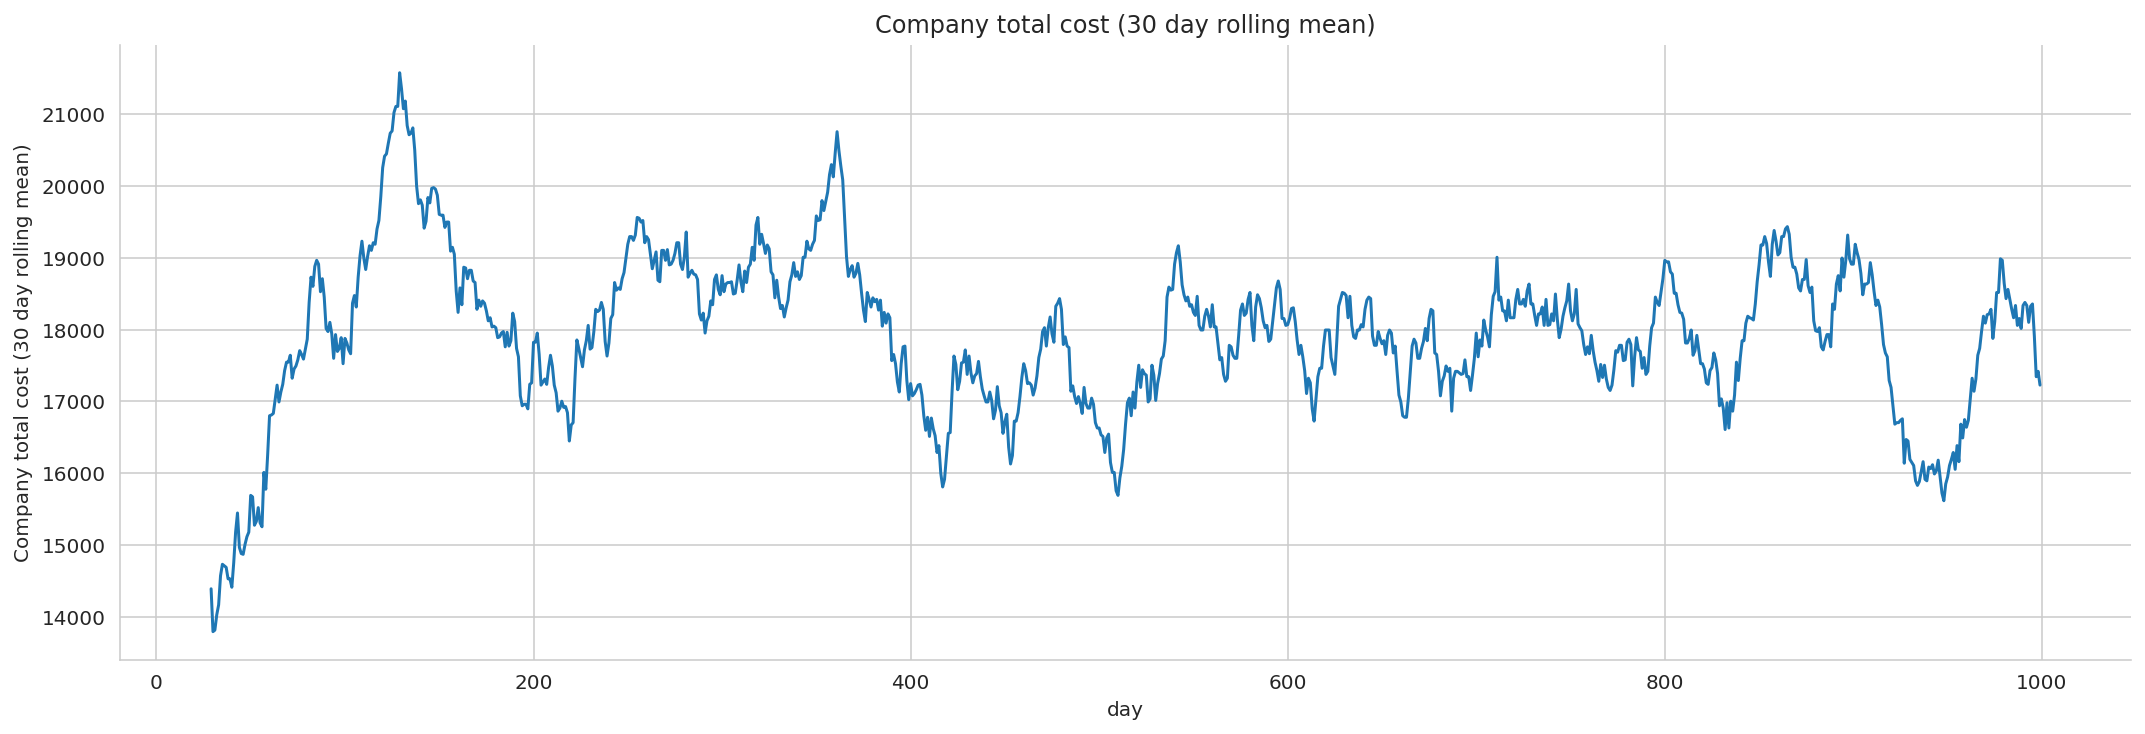

In [21]:
tdf = sim[['day', 'org_net_cost']]
tdf['Company total cost (30 day rolling mean)'] = tdf['org_net_cost'].rolling(30).mean()
sns.relplot(x='day', y='Company total cost (30 day rolling mean)', data=tdf, kind='line', aspect=3)
plt.title('Company total cost (30 day rolling mean)')

### 30-day rolling work and train cost

<ipython-input-484-2d10ed0c56e1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf['Company train cost (30 day rolling mean)'] = tdf['org_train_cost'].rolling(30).mean()
<ipython-input-484-2d10ed0c56e1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf['Company work cost (30 day rolling mean)'] = tdf['org_work_cost'].rolling(30).mean()


Text(0.5, 1.0, 'Company working/training costs (30 day rolling mean)')

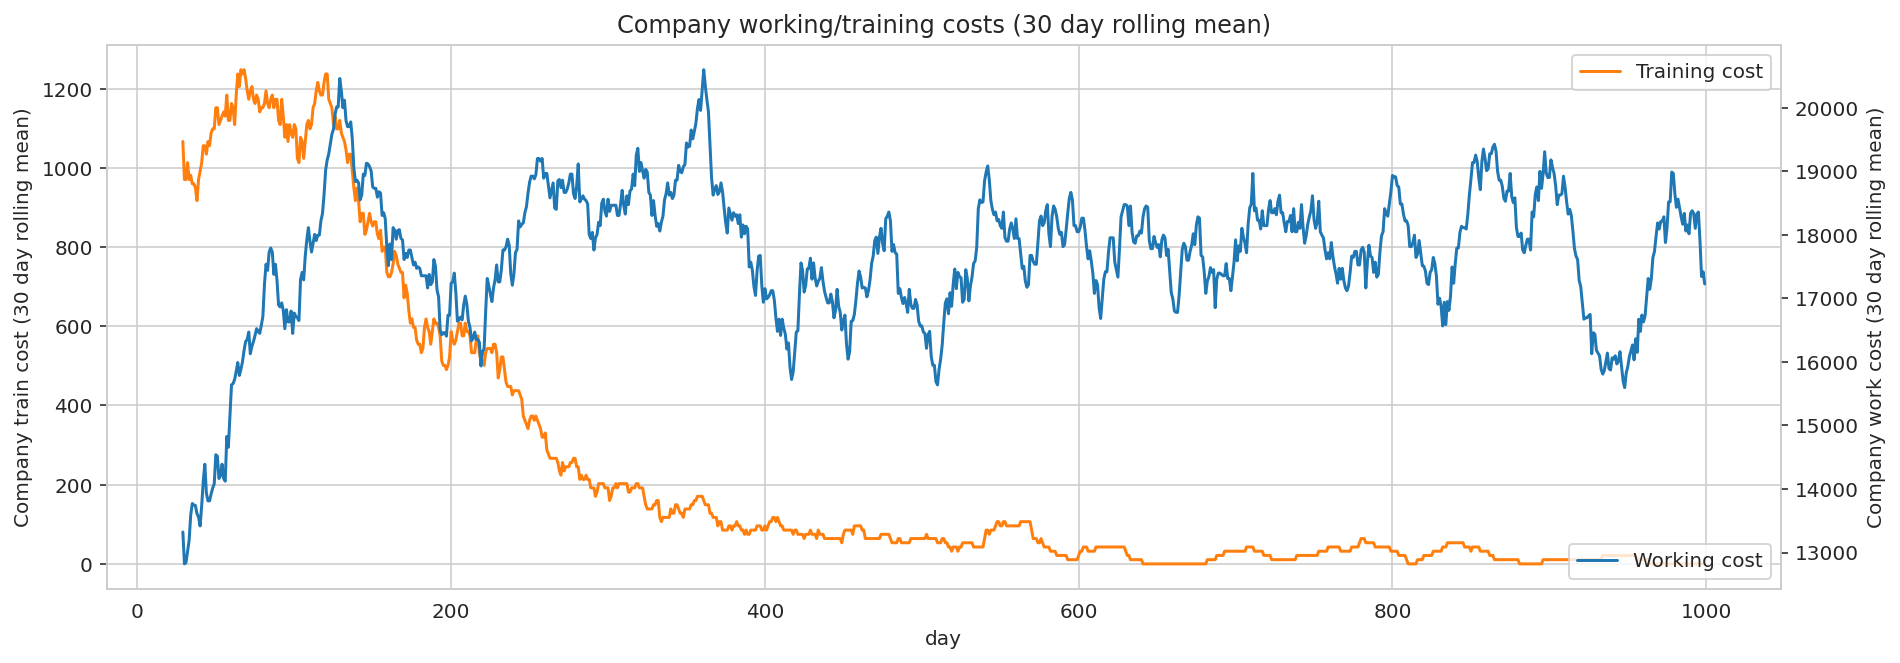

In [484]:
tdf = sim[['day', 'org_train_cost', 'org_work_cost']]
tdf['Company train cost (30 day rolling mean)'] = tdf['org_train_cost'].rolling(30).mean()
tdf['Company work cost (30 day rolling mean)'] = tdf['org_work_cost'].rolling(30).mean()

fig, ax = plt.subplots(figsize=(15, 5))
ax2 = ax.twinx()
ax2.grid(False)
sns.lineplot(x='day', y='Company work cost (30 day rolling mean)', data=tdf, color=sns.color_palette()[0], label='Working cost', ax=ax2)
sns.lineplot(x='day', y='Company train cost (30 day rolling mean)', data=tdf, color=sns.color_palette()[1], label='Training cost', ax=ax)

ax.legend(loc='upper right')
ax2.legend(loc='lower right')

plt.title('Company working/training costs (30 day rolling mean)')

### Team wise skill upgrade over time

Text(0.5, 1.0, 'Team skills upgrade trend')

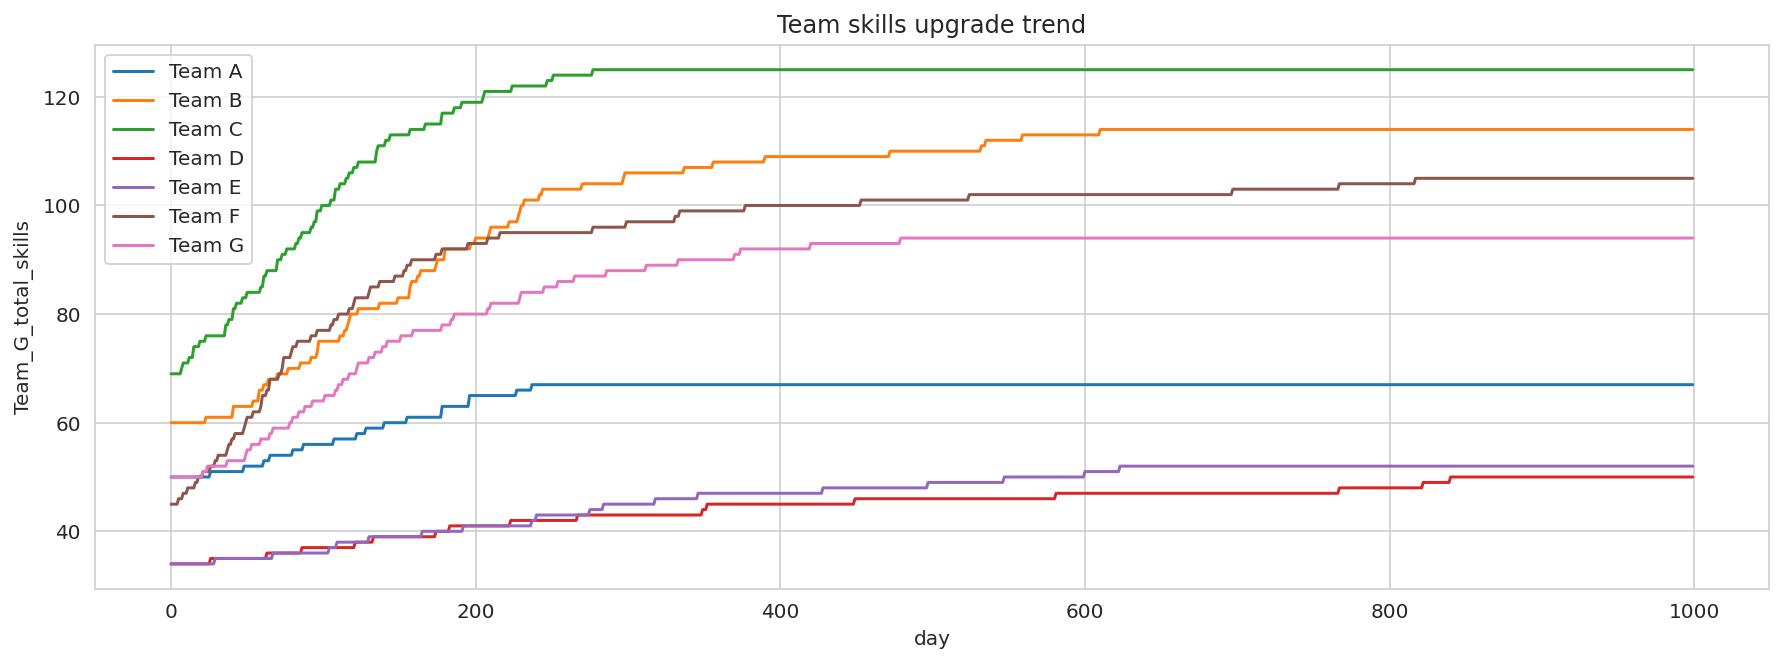

In [485]:
fig, ax = plt.subplots(figsize=(15, 5))
for i, team in enumerate(teams):
    sns.lineplot(x='day', y=f'Team_{team}_total_skills', ax=ax, data=sim, color=sns.color_palette()[i], label=f'Team {team}')
plt.title('Team skills upgrade trend')

### Go home vs Cross-training team success count

Text(0.5, 1.0, 'Number of teams that find a feasible solution (30-day rolling average)')

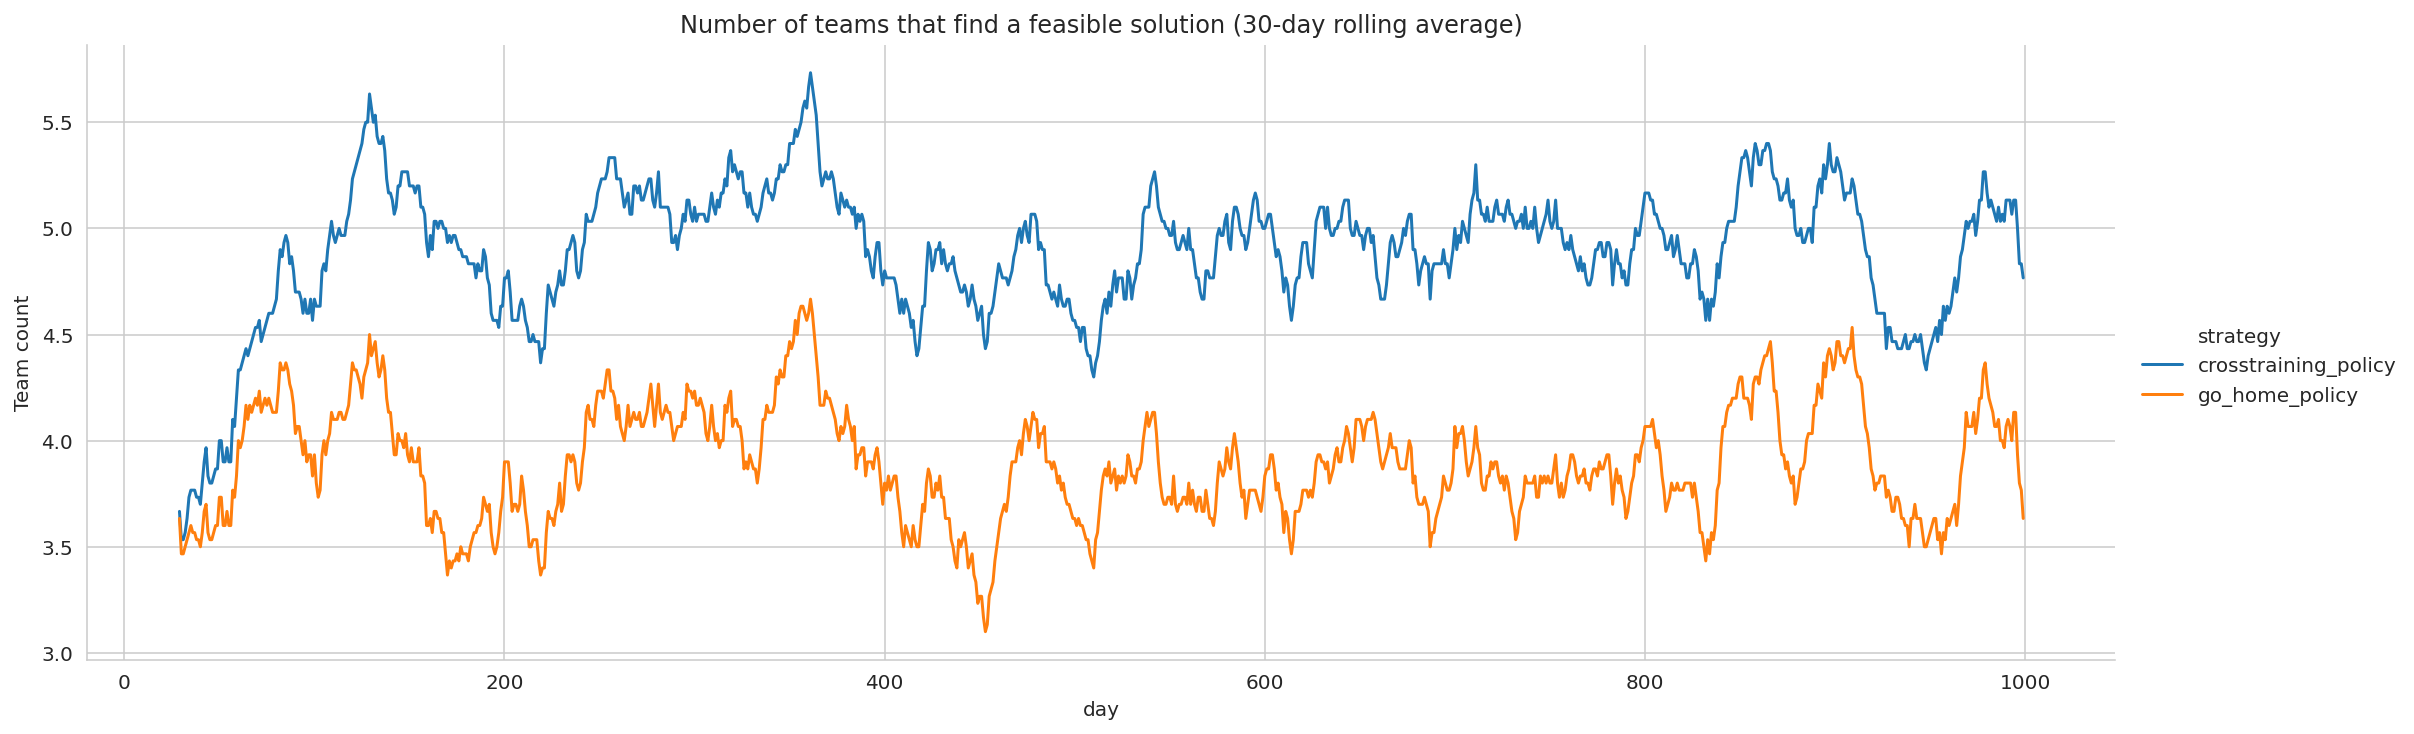

In [44]:
g = (
    sim[['day', 'all_team_sol_flag', 'all_team_gohome_sol_flag']]
    .assign(
        crosstraining_policy = lambda x: x['all_team_sol_flag'].rolling(30).mean(),
        go_home_policy = lambda x: x['all_team_gohome_sol_flag'].rolling(30).mean()
    )
    .melt(id_vars='day', value_vars=['crosstraining_policy', 'go_home_policy'], var_name='strategy', value_name='Team count')
    .pipe((sns.relplot, 'data'), x='day', y='Team count', hue='strategy', kind='line', aspect=3)
)
plt.title('Number of teams that find a feasible solution (30-day rolling average)')

### Go home vs cross-training cost

<ipython-input-38-55e9cf0807bb>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf[f'Team_{team}_crosstrain_cost'] = tdf[f'Team_{team}_work_cost'] + tdf[f'Team_{team}_train_cost']


Text(0.5, 1.0, 'Company overall cost for crosstraining and go home strategies for Team C')

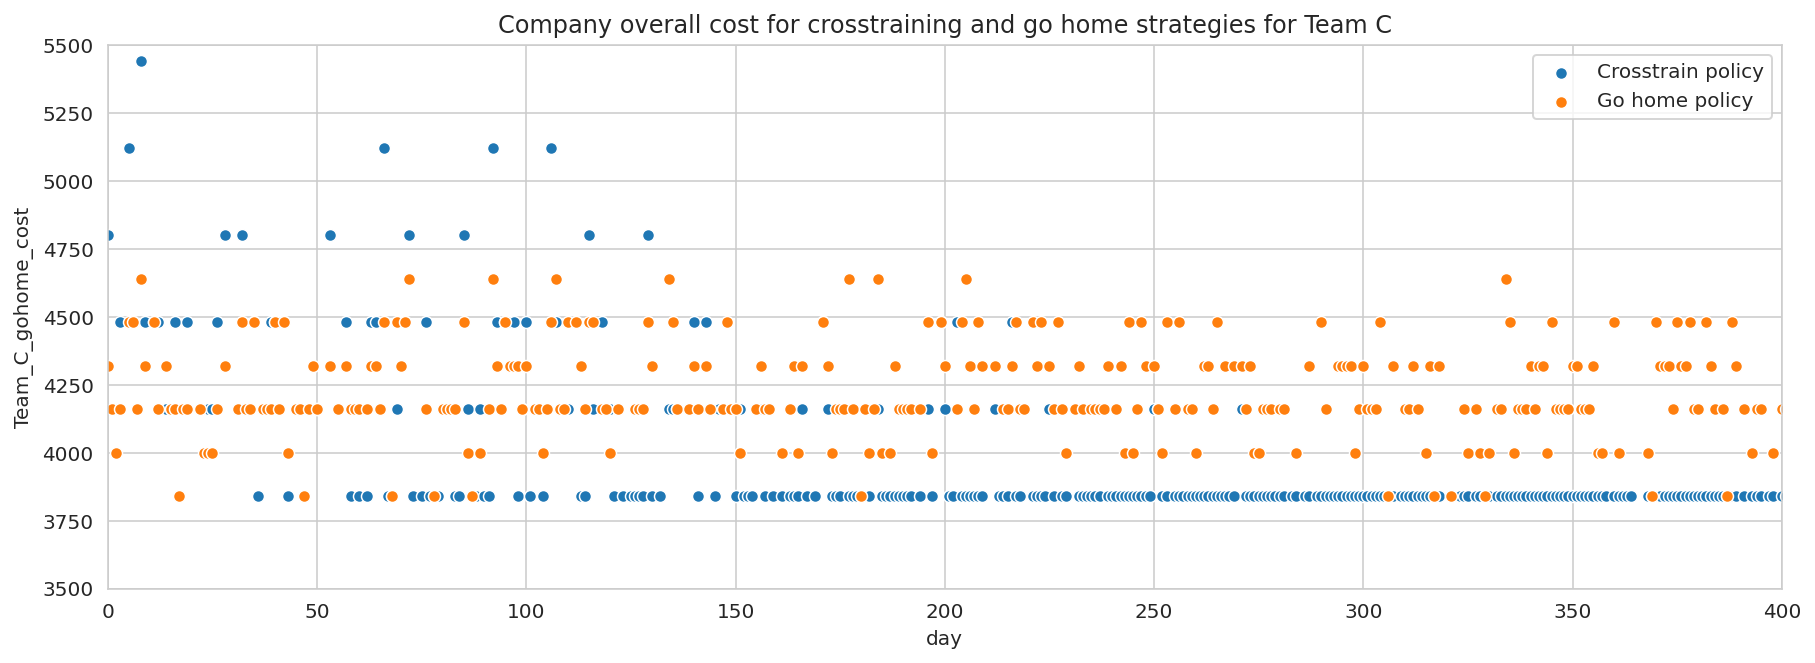

In [38]:
team = 'C'

tdf = sim[['day', f'Team_{team}_skill_sol_flag', f'Team_{team}_gohome_cost', f'Team_{team}_train_cost', f'Team_{team}_work_cost']]
tdf[f'Team_{team}_crosstrain_cost'] = tdf[f'Team_{team}_work_cost'] + tdf[f'Team_{team}_train_cost']
# tdf = tdf[tdf['day'] <= 400]

fig, ax = plt.subplots(figsize=(15, 5))

sns.scatterplot(x='day', y=f'Team_{team}_crosstrain_cost', data=tdf, ax=ax, color=sns.color_palette()[0], label='Crosstrain policy')
sns.scatterplot(x='day', y=f'Team_{team}_gohome_cost', data=tdf, ax=ax, color=sns.color_palette()[1], label='Go home policy')
ax.set_xlim(0, 400)
ax.set_ylim(3500, 5500)
plt.title(f'Company overall cost for crosstraining and go home strategies for Team {team}')

### Improvement of preference matching from skill based to preference based assignment

Text(0.5, 1.0, 'Preference improvement after preference-based assigment')

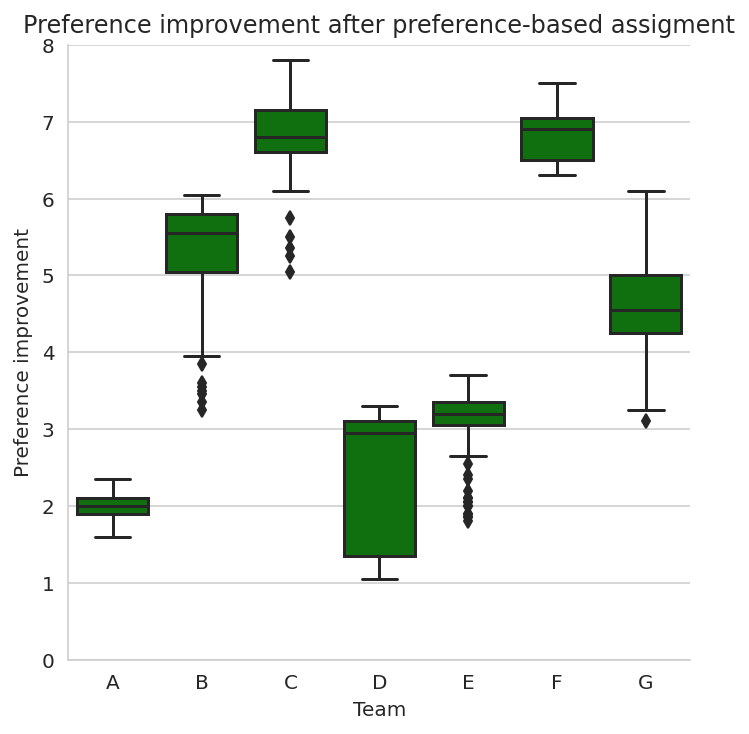

In [114]:
tmp = (
    sim
    .dropna(subset=[x for x in sim.columns if 'pref_match' in x])
    .copy()
)
keep_cols = ['day']
for team in teams:
    this_col = f'{team}'
    tmp[this_col] = tmp[f'Team_{team}_pref_match_after_pref'] - tmp[f'Team_{team}_pref_match_after_skill']
    tmp[this_col] = tmp[this_col].rolling(20).mean()
    keep_cols.append(this_col)

g = (
    tmp[keep_cols]
    .reset_index(drop=True)
    .assign(day = lambda x: x.index)
    .melt(id_vars='day', value_vars=list(set(keep_cols) - set(['day'])), var_name='Team', value_name='Preference improvement')
    .pipe((sns.catplot, 'data'), x='Team', y='Preference improvement', aspect=1, kind='box', color='green', order=teams)
)
g.ax.set_ylim(0, 8)
g.ax.set_title('Preference improvement after preference-based assigment')